<a href="https://colab.research.google.com/github/HuyenNguyenHelen/LING-5412/blob/main/Final_project/ClassicML-LSTM-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tarfile
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree             # tree.DecisionTreeClassifier()
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm #clf = svm.SVC(decision_function_shape='ovo')
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, roc_auc_score

import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import torch
import sklearn
from sklearn.metrics import accuracy_score, classification_report
tfds.disable_progress_bar()
from keras import backend as K

In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
# import gensim
# import gensim.downloader as api
# nlp = api.load('word2vec-google-news-300')

# Loading data

In [ ]:

# Unzip the dataset
#!unzip "/content/dontpatronizeme_v1.3.zip" -d "/content/drive/MyDrive/"

In [ ]:
# Opening the file from MyDrive
file = open(r'/content/drive/MyDrive/dontpatronizeme_v1.3/dontpatronizeme_pcl.tsv')
reader = csv.reader(file, delimiter="\t")
data = []
for row in reader:
  data.append(row)


In [ ]:
df = pd.DataFrame(data[5:],  columns = ['docID', 'keyword', 'country', 'paragraph', 'label' ] )
df

,docID,keyword,country,paragraph,label
0,@@4703096,immigrant,jm,NBC and Spanish-language Univision both declin...,0
1,@@25567226,in-need,hk,A second T-Home project is being launched in t...,0
2,@@1824078,poor-families,tz,Camfed would like to see this trend reversed ....,4
3,@@1921089,refugee,tz,Kagunga village was reported to lack necessary...,0
4,@@40039380,women,ng,Haruna stressed the need for specific approach...,0
...,...,...,...,...,...
10053,@@16413808,immigrant,my,"To me , I am always mindful that we are dealin...",4
10054,@@8676630,vulnerable,jm,Other themes included promoting the inclusion ...,0
10055,@@7688552,immigrant,gb,It came as the CDU was also humiliated by the ...,0
10056,@@4916290,hopeless,in,"Those were only days of helplessness , she say...",0


# Exploring data

In [ ]:
# Length of text
def length (txt):
  length = len(txt.split())
  return length

txt_length = df['paragraph'].apply(lambda x: length(x))
txt_length.sort_values(ascending = False)

3534    1519
6266    1095
8519    1040
4613     772
8819     729
        ... 
1930       4
1385       3
7375       3
5112       3
5742       0
Name: paragraph, Length: 10058, dtype: int64

In [ ]:
# Observing labels
df['label'].value_counts()

0    8206
1     906
3     435
4     369
2     142
Name: label, dtype: int64

In [ ]:
df['label'] = df['label'].astype(str)
df['label']

0        0
1        0
2        4
3        0
4        0
        ..
10053    4
10054    0
10055    0
10056    0
10057    0
Name: label, Length: 10058, dtype: object

In [ ]:
# Missing data
#checking missing values
print('Is null: \n', df.isnull().sum() )


Is null: 
 docID        0
keyword      0
country      0
paragraph    0
label        0
dtype: int64


0    9112
1     946
Name: label, dtype: int64


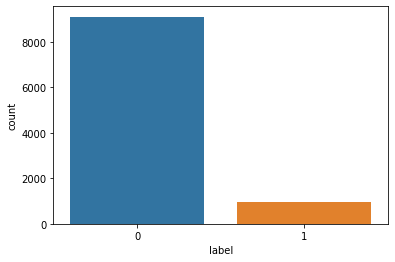

In [ ]:
# Turning labels to binary

label_dic = {'0':0,
             '1':0,
             '2':1,
             '3':1,
             '4':1}
df['label'] = df['label'].map(label_dic)
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.show()

# Developing models

In [ ]:
# Splitting the data into training (80%) and test set(20%)
from sklearn.model_selection import train_test_split
X = df['paragraph']
y = df['label']
X_train_large, X_test, y_train_large, y_test = train_test_split (X, y, train_size = 0.8, random_state = 42, shuffle = True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split (X_train_large, y_train_large, train_size = 0.8, random_state = 42, shuffle = True, stratify=y_train_large)

print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_val, y_val: ', X_test.shape, y_test.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)
print(y_train.value_counts())

Shapes of X_train, y_train:  (6436,) (6436,)
Shapes of X_val, y_val:  (2012,) (2012,)
Shapes of X_test, y_test:  (2012,) (2012,)
0    5830
1     606
Name: label, dtype: int64


In [ ]:
y_test.value_counts()

0    1823
1     189
Name: label, dtype: int64

## Classic ML models


### Text representation

In [ ]:
!pip install stop-words
from stop_words import get_stop_words
stopwords = get_stop_words('en')
from textblob import Word
import re
import nltk
nltk.download('wordnet')

#BOW based approaches
nlp.init_sims(replace=True) # calling for using syn0norm

def word_averaging(wv, words):
    all_words, mean = set(), []
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)
    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32912 sha256=db9addeff132897a4c356695270ed834f3daf2ffbd17b4cc056ce93c1c7bc213
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Tokenize, and apply word vector averaging to tokenized text
import nltk
nltk.download('punkt')
import logging
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    

X_train_tokenized = X_train.apply(lambda x: w2v_tokenize_text(x)).values
X_test_tokenized = X_test.apply(lambda x: w2v_tokenize_text(x)).values

X_train_word_average = word_averaging_list(nlp,X_train_tokenized)
X_test_word_average = word_averaging_list(nlp,X_test_tokenized)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).


### Creating models

In [ ]:
# # Printing model performance 
# def printing_eval_scores (y_true, y_pred):
#   print('accuracy score: {}'.format(sklearn.metrics.accuracy_score(y_true, y_pred)))
#   print('precision score: {}'.format(sklearn.metrics.precision_score(y_true, y_pred, average = 'weighted', zero_division=1)))
#   print('recall score: {}'.format(sklearn.metrics.recall_score(y_true, y_pred,  average = 'weighted', zero_division=1)))
#   print('F1 score: {}'.format(sklearn.metrics.f1_score(y_true, y_pred,  average = 'weighted', zero_division=1)))
#   print(classification_report(y_true, y_pred))

In [ ]:
# Defining an evaluation metric function
def printing_eval_scores (y_true, y_pred, report=''):
  accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
  precision = sklearn.metrics.precision_score(y_true, y_pred, average='binary')
  recall = sklearn.metrics.recall_score(y_true, y_pred, average='binary')
  f1 = sklearn.metrics.f1_score(y_true, y_pred , average='binary')
  print('accuracy score: {:.3f}'.format(accuracy))
  print('precision score: {:.3f}'.format(precision))
  print('recall score: {:.3f}'.format(recall))
  print('F1 score: {:.3f}'.format(f1))
  if report is True:
    print(classification_report(y_true, y_pred))
  else:
    pass
  return accuracy, precision, recall, f1

In [ ]:
# Define a function for creating over sampling 
def score_model(model):
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)

    oversampler = SMOTE(random_state=42)
    #oversampler = RandomOverSampler(sampling_strategy='minority')
    scores = []

    ## on training set, do cv
    for train_fold_index, val_fold_index in cv.split(X_train_word_average, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train_word_average[train_fold_index], y_train.iloc[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train_word_average[val_fold_index], y_train.iloc[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = oversampler.fit_resample(X_train_fold,
                                                                           y_train_fold)
        # Fit the model on the upsampled training data
        model.fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = accuracy_score(y_val_fold, model.predict(X_val_fold)) #  average= 'weighted' for F1
        scores.append(score)
    print('Average of acuracy score in training: %s' % np.array(scores).mean())

    ## on test set
    y_pred = model.predict(X_test_word_average)
    test_score = accuracy_score( y_test,y_pred)
    printing_eval_scores (y_test, y_pred)
    report_scores = {'accuracy_folds':np.array(scores),'accuracy_test':test_score, 'y_predicted':y_pred }
    return report_scores #(np.array(scores),test_score,y_pred )       #(np.array(scores).mean(), np.array(scores).std())

Average of acuracy score in training: 0.7895843643480578
accuracy score: 0.794234592445328
precision score: 0.9020001923515237
recall score: 0.794234592445328
F1 score: 0.8312229337890593
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      1823
           1       0.28      0.74      0.40       189

    accuracy                           0.79      2012
   macro avg       0.62      0.77      0.64      2012
weighted avg       0.90      0.79      0.83      2012

LR: 0.789584 (0.014373)
Average of acuracy score in training: 0.8972159707236853
accuracy score: 0.8881709741550696
precision score: 0.859459956477054
recall score: 0.8881709741550696
F1 score: 0.8708209934332249
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1823
           1       0.31      0.15      0.20       189

    accuracy                           0.89      2012
   macro avg       0.61      0.56      0.57      2012


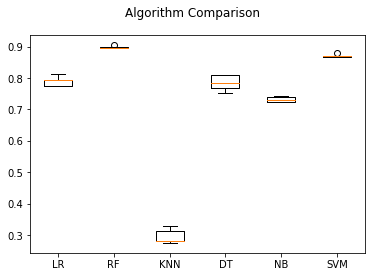

In [ ]:
# Running all models together
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=700)))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(decision_function_shape='ovo', probability=True)))
# evaluate each model in turn
results = []
score_test = []
names = []
report_scores_all = []
for name, model in models:
  report_scores = score_model(model)
  report_scores_all.append(report_scores)
  results.append(report_scores['accuracy_folds'])
  score_test.append(report_scores['accuracy_test'])
  names.append(name)
  # msg = "%s: %f (%f)" % (name, fold_scores.mean(), fold_scores.std())
  msg = "%s: %f (%f)" % (name, report_scores['accuracy_folds'].mean(), report_scores['accuracy_folds'].std())
  print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## LSTM-based models

In [ ]:
# Defining an evaluation metric function
def get_roc_curve (y_true, y_pred):
  # Get arrays of FPR and recall using roc_curve
  FPR, recall, threshold = sklearn.metrics.roc_curve(y_true, y_pred)
  # Get auc score
  auc = sklearn.metrics.auc(FPR, recall)
  roc = { 'fpr': FPR, 'tpr': recall, 'auc': auc}
  return roc

def printing_eval_scores (y_true, y_pred, report=''):
  accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
  precision = sklearn.metrics.precision_score(y_true, y_pred, average='macro', zero_division = 1)
  recall = sklearn.metrics.recall_score(y_true, y_pred, average='macro', zero_division = 1)
  f1 = sklearn.metrics.f1_score(y_true, y_pred , average='macro', zero_division = 1)
  cmatrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
  print('accuracy score: {:.3f}'.format(accuracy))
  print('precision score: {:.3f}'.format(precision))
  print('recall score: {:.3f}'.format(recall))
  print('F1 score: {:.3f}'.format(f1))
  if report is True:
    print(classification_report(y_true, y_pred))
  else:
    pass
  return accuracy, precision, recall, f1

roc = {}

In [ ]:
# Set up parameters
n_epochs = 15
n_units = 64
optimizer = 'rmsprop'
MAX_SEQUENCE_LENGTH = 120

### Oversampling

In [ ]:
# Oversampling
bool1_train_labels = y_train != 0

X_train_1 = X_train[bool1_train_labels]
X_train_0 = X_train[~bool1_train_labels]

y_train_1 = y_train[bool1_train_labels]
y_train_0 = y_train[~bool1_train_labels]

print('shape of X_train - Class 1: {}, Class 0: {}'.format(X_train_1.shape, X_train_0.shape))
print('shape of y_train - Class 1: {}, Class 0: {}'.format(y_train_1.shape, y_train_0.shape))

# Oversampling the class 1
ids = np.arange(len(X_train_1.to_list()))
choices = np.random.choice(ids, size = len(X_train_0.to_list()))

res_X_train_1 = np.array(X_train_1.to_list())[choices]
res_y_train_1 = np.array(y_train_1)[choices]

print('\nWith oversampling: \nshape of X_train - Class 1: {}, Class 0: {}'.format(res_X_train_1.shape, X_train_0.shape))
print('shape of y_train - Class 1: {}, Class 0: {}'.format(res_y_train_1.shape, y_train_0.shape))

# Concatenate oversalmpled class 1, and class 0
res_X_train = np.concatenate([res_X_train_1, X_train_0], axis=0)
res_y_train = np.concatenate([res_y_train_1, y_train_0], axis=0)

# Shuffle after concatenate the two-class data.
order = np.arange(len(res_y_train))
np.random.shuffle(order)
#np.random.shuffle(order)
res_X_train = res_X_train[order]
res_y_train = res_y_train[order]

print('\nWith oversampling and shuffling: \nshape of resampled_X_train: {}, resampled_y_train: {}'.format(res_X_train.shape, res_y_train.shape))


shape of X_train - Class 1: (606,), Class 0: (5830,)
shape of y_train - Class 1: (606,), Class 0: (5830,)

With oversampling: 
shape of X_train - Class 1: (5830,), Class 0: (5830,)
shape of y_train - Class 1: (5830,), Class 0: (5830,)

With oversampling and shuffling: 
shape of resampled_X_train: (11660,), resampled_y_train: (11660,)


### Text representation

In [ ]:
# Uncomment these codes for running with other Google account
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip -d "/content/drive/MyDrive/"

In [ ]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train.to_list()+X_val.to_list()).batch(32)
vectorizer.adapt(text_ds)
print(vectorizer.get_vocabulary()[:5])

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

['', '[UNK]', 'the', 'to', 'of']


In [ ]:
#X_train_vec = vectorizer(np.array([[s] for s in X_train.to_list()])).numpy()
X_train_vec = vectorizer(np.array(res_X_train)).numpy()
X_val_vec = vectorizer(np.array([[s] for s in X_val.to_list()])).numpy()
X_test_vec = vectorizer(np.array([[s] for s in X_test.to_list()])).numpy()

y_train = res_y_train #np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
embeddings_index = {}
EMBEDDING_DIM = 300
hits = 0
misses = 0

f = open(os.path.join('/content/drive/MyDrive', 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 17967 words (2033 misses)


In [ ]:
embedding_matrix.shape

(20001, 300)

### Vanilla biLSTM

In [ ]:
#### Creating the model ########
input_dim = len(word_index) + 1

## Block 1
embedding_layer = tf.keras.layers.Embedding(input_dim = input_dim,
                                            output_dim = EMBEDDING_DIM, 
                                            weights=[embedding_matrix],   
                                            trainable=True,
                                            mask_zero = True) # turn into dense vector representation
sequence_input = tf.keras.Input(shape=(X_train_vec.shape[1],), dtype=tf.int64)
embedded_sequences = embedding_layer(sequence_input)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units,  return_sequences = False,  trainable=True)) (embedded_sequences) # take inputs of embeddings, and all output hidden states with return_sequences = True
x = tf.keras.layers.Dense(32, activation = 'relu') (x)
x = tf.keras.layers.Dropout(0.2) (x)

## output layer
output = tf.keras.layers.Dense(1, activation = 'sigmoid') (x)

## combine in one
model = tf.keras.Model(sequence_input,output)
print(model.summary())

## Compile the model for training
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              optimizer = optimizer, 
              metrics = ['accuracy'])

# Training the model

history = model.fit(X_train_vec, y_train, validation_data=(X_val_vec, y_val),
          epochs=n_epochs, batch_size=32)


# testing the model
### pred_label = tf.argmax(model.predict(test),1)
pred_label = (model.predict(X_test_vec) > 0.5).astype("int32")
true_label = y_test 

test_loss, test_acc = model.evaluate (X_test_vec,y_test)
print('Test acurracy: ', test_acc)
print('\nTesting performance:\n Loss: {:.3f} - Accuracy: {:.3f}'. format(test_loss, test_acc))
printing_eval_scores (true_label, pred_label, report=True)
roc['vanila-biLSTM'] = get_roc_curve(true_label, pred_label)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          6000300   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                             

### Stacked biLSTM

In [ ]:
#### Creating the model ########
input_dim = len(word_index) + 1

## Block 1
#x = encoder (_input) # vectorize the data input 
embedding_layer = tf.keras.layers.Embedding(input_dim = input_dim,
                                            output_dim = EMBEDDING_DIM, 
                                            weights=[embedding_matrix],  #embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
                                            trainable=True,
                                            mask_zero = True) # turn into dense vector representation
sequence_input = tf.keras.Input(shape=(X_train_vec.shape[1],), dtype=tf.int64)
embedded_sequences = embedding_layer(sequence_input)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units,  return_sequences = True,  trainable=True)) (embedded_sequences) # take inputs of embeddings, and all output hidden states with return_sequences = True
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units,  return_sequences = False,  trainable=True)) (x) 
x = tf.keras.layers.Dense(32, activation = 'relu') (x)
x = tf.keras.layers.Dropout(0.2) (x)
## output layer
output = tf.keras.layers.Dense(1, activation = 'sigmoid') (x)

## combine in one
model = tf.keras.Model(sequence_input,output)
print(model.summary())

## Compile the model for training
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              optimizer = optimizer, 
              metrics = ['accuracy'])

# Training the model

history = model.fit(X_train_vec, y_train, validation_data=(X_val_vec, y_val),
          epochs=n_epochs, batch_size=32)


# testing the model
### pred_label = tf.argmax(model.predict(test),1)
pred_label = (model.predict(X_test_vec) > 0.5).astype("int32")
true_label = y_test #np.concatenate([y for x, y in test_dataset], axis=0)

test_loss, test_acc = model.evaluate (X_test_vec,y_test)
print('Test acurracy: ', test_acc)
print('\nTesting performance:\n Loss: {:.3f} - Accuracy: {:.3f}'. format(test_loss, test_acc))
printing_eval_scores (true_label, pred_label, report=True)
roc['stacked-biLSTM'] = get_roc_curve(true_label, pred_label)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 300)          6000300   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 128)         186880    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0   

### biLSTM with attention

In [ ]:
#### Creating the model ########
input_dim = len(word_index) + 1

## Block 1
embedding_layer = tf.keras.layers.Embedding(input_dim = input_dim,
                                            output_dim = EMBEDDING_DIM, 
                                            weights=[embedding_matrix],  #embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
                                            trainable=True,
                                            mask_zero = True) # turn into dense vector representation
sequence_input = tf.keras.Input(shape=(X_train_vec.shape[1],), dtype=tf.int64)
embedded_sequences = embedding_layer(sequence_input)

lstm_hs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units,  return_sequences = True,  trainable=True)) (embedded_sequences) # take inputs of embeddings, and all output hidden states with return_sequences = True

# attention layer
attention = tf.keras.layers.Dense(1, activation = 'tanh') (lstm_hs) #apply tanh activation function for all hidden states LSTM produced
attention = tf.keras.layers.Flatten()(attention) # transform tensor of attention weights in a vector 
attention = tf.keras.layers.Activation('softmax') (attention) # applying softmax activation function of the hidden states output to get attention weights between 0 and 1, and sum to 1
attention = tf.keras.layers.RepeatVector (n_units*2) (attention) # repeat attention weights to have same dimensions with hidden states (= unit*2 as it's biLSTM) for compute element-wise multiplying
attention = tf.keras.layers.Permute ([2,1]) (attention) # permute the dimension of the attention weight for being able to multiply with hidden states

attention_weight = tf.keras.layers.Multiply()([lstm_hs, attention]) # computing element-wise mutiplying hidden states with the attention weight as updated sentence representations
attention_weight = tf.keras.layers.Lambda(lambda x: K.sum(x, axis = 1)) (attention_weight) # summing up all weights in the updated sentence representation for unputing into a fully-connected layer at the end 

## output layer
dropout = tf.keras.layers.Dropout(0.2) (attention_weight)
output = tf.keras.layers.Dense(1, activation = 'sigmoid') (dropout)

## combine in one
model = tf.keras.Model(sequence_input,output)
print(model.summary())

## Compile the model for training
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              optimizer = optimizer, #tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics = ['accuracy'])

# Training the model

history = model.fit(X_train_vec, y_train, validation_data=(X_val_vec, y_val),
          epochs=n_epochs, batch_size=32)


# testing the model
pred_label = (model.predict(X_test_vec) > 0.5).astype("int32")
true_label = y_test #np.concatenate([y for x, y in test_dataset], axis=0)

test_loss, test_acc = model.evaluate (X_test_vec,y_test)
print('Test acurracy: ', test_acc)
print('\nTesting performance:\n Loss: {:.3f} - Accuracy: {:.3f}'. format(test_loss, test_acc))
printing_eval_scores (true_label, pred_label, report=True)
roc['att-biLSTM'] = get_roc_curve(true_label, pred_label)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 200, 300)     6000300     ['input_3[0][0]']                
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 200, 128)    186880      ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 dense_4 (Dense)                (None, 200, 1)       129         ['bidirectional_3[0][0]']  

## CNN

In [ ]:
n_epochs = 20
n_units = 64
optimizer = 'adam'
MAX_SEQUENCE_LENGTH = 120

#### Creating the model ########
input_dim = len(word_index) + 1

## Embedding layer
embedding_layer = tf.keras.layers.Embedding(input_dim = input_dim,
                                            output_dim = EMBEDDING_DIM, 
                                            weights=[embedding_matrix],  #embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
                                            trainable=True,
                                            mask_zero = True) # turn into dense vector representation
sequence_input = tf.keras.Input(shape=(X_train_vec.shape[1],), dtype=tf.int64)
embedded_sequences = embedding_layer(sequence_input)

# CNN layers
x = tf.keras.layers.Conv1D(n_units, 5 , activation='relu') (embedded_sequences)
x = tf.keras.layers.MaxPooling1D() (x)
x = tf.keras.layers.Flatten() (x)
x = tf.keras.layers.Dense(32, activation='relu') (x) #
x = tf.keras.layers.Dropout(0.2) (x)

## output layer
output = tf.keras.layers.Dense(1, activation = 'sigmoid') (x)

## combine in one
model = tf.keras.Model(sequence_input,output)
print(model.summary())

## Compile the model for training
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              optimizer = optimizer, #tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics = ['accuracy'])

# Training the model

history = model.fit(X_train_vec, y_train, validation_data=(X_val_vec, y_val),
          epochs=n_epochs, batch_size=32)


# testing the model
### pred_label = tf.argmax(model.predict(test),1)
pred_label = (model.predict(X_test_vec) > 0.5).astype("int32")
true_label = y_test #np.concatenate([y for x, y in test_dataset], axis=0)

test_loss, test_acc = model.evaluate (X_test_vec,y_test)
print('Test acurracy: ', test_acc)
print('\nTesting performance:\n Loss: {:.3f} - Accuracy: {:.3f}'. format(test_loss, test_acc))
printing_eval_scores (true_label, pred_label, report=True)
roc['CNN'] = get_roc_curve(true_label, pred_label)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 200, 300)          6000300   
                                                                 
 conv1d (Conv1D)             (None, 196, 64)           96064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 64)           0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                200736    
                                                           

In [ ]:
roc

{'CNN': {'auc': 0.5476988625644686,
  'fpr': array([0.        , 0.01042238, 1.        ]),
  'tpr': array([0.        , 0.10582011, 1.        ])},
 'att-biLSTM': {'auc': 0.5735081135519972,
  'fpr': array([0.        , 0.01700494, 1.        ]),
  'tpr': array([0.        , 0.16402116, 1.        ])},
 'stacked-biLSTM': {'auc': 0.5689426986739109,
  'fpr': array([0.        , 0.02084476, 1.        ]),
  'tpr': array([0.        , 0.15873016, 1.        ])},
 'vanila-biLSTM': {'auc': 0.5503443652099714,
  'fpr': array([0.        , 0.01042238, 1.        ]),
  'tpr': array([0.        , 0.11111111, 1.        ])}}

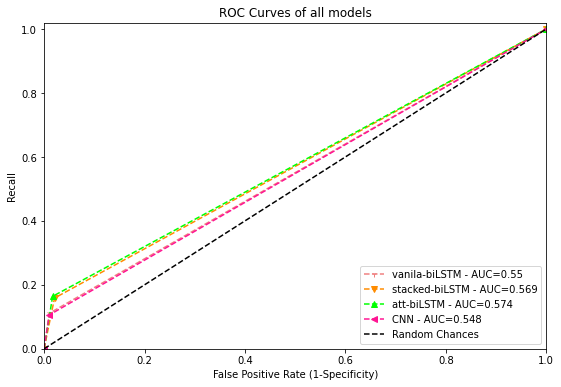

In [ ]:
def graph_multi_ROC (rocs):
  # Set color for each model
  colors = {'vanila-biLSTM': 'lightcoral','stacked-biLSTM': 'darkorange', 'att-biLSTM':'lime', 'CNN': 'deeppink'} #, 'NB': 'steelblue',  'XGB': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise','BERT': 'darkred', 'GPT': 'blue'
  # Set marker for each model          
  markers = {'vanila-biLSTM':'1--','stacked-biLSTM': 'v--', 'att-biLSTM': '^--', 'CNN':'<--'} #, 'XGB': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))
  for model in rocs:
    plt.plot( rocs[model]['fpr'], rocs[model]['tpr'], markers[model], color=colors[model], label= model+' - AUC=' + str(rocs[model]['auc'].round(3)) )
  
  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'ROC Curves of all models')
  plt.show()

graph_multi_ROC(roc)

In [ ]:
# Export performance to a txt file
txtfile = open('LSTM-CNN_rocs.txt','w')
for i in roc.keys():
  txtfile.write(str(i) + '=' + str(roc[i])+'\n')
  print(roc[i])
txtfile.close()

{'fpr': array([0.        , 0.01042238, 1.        ]), 'tpr': array([0.        , 0.11111111, 1.        ]), 'auc': 0.5503443652099714}
{'fpr': array([0.        , 0.02084476, 1.        ]), 'tpr': array([0.        , 0.15873016, 1.        ]), 'auc': 0.5689426986739109}
{'fpr': array([0.        , 0.01700494, 1.        ]), 'tpr': array([0.        , 0.16402116, 1.        ]), 'auc': 0.5735081135519972}
{'fpr': array([0.        , 0.01042238, 1.        ]), 'tpr': array([0.        , 0.10582011, 1.        ]), 'auc': 0.5476988625644686}
